# Severity of adverse reactions in pediatric patients

## Data collection and cleaning

We will first collect the data. We will initially collect only data for 'children' i.e. category 3 as reported in the database. This does not include neonates, infants or adolescents.

Given the total number of children in the database (35,000), we will initially restrict our analyses to the first 5000. The sample can be expanded or reduced by changing n_reports.

In [1]:
# import standard modules necessary for data processing and visualisation
# set style for plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import scipy.stats as st
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10.0, 6.0)

# import my modules
import collect_data 
import clean_data
import process_data

# define the base of the URL used to access the database
# search terms will be appended to this to obtain specific recordsets
url_base = "https://api.fda.gov/drug/event.json?search=receivedate:[20030101+TO+20200528]"

### Collecting the pediatric dataset

In [2]:
n_reports = 200

# collect pediatric data from database and flatten
raw_pediatric = collect_data.collect_pediatric_data(n_reports)
raw_pediatric.reset_index(drop=True, inplace=True)
flat_pediatric = collect_data.flatten_dataframe(raw_pediatric)

In [3]:
flat_pediatric.head(5)

,reporttype,receiptdateformat,companynumb,occurcountry,safetyreportversion,receivedateformat,duplicate,transmissiondateformat,fulfillexpeditecriteria,safetyreportid,...,rxcui,spl_id,substance_name,product_type,route,application_number,nui,pharm_class_cs,pharm_class_epc,pharm_class_moa
0,1,102,US-GILEAD-2012-0061944,US,3,102,1,102,2,10003430,...,722124,acf09b42-e9a4-4aee-82f7-75d413d06ec5,AMBRISENTAN,HUMAN PRESCRIPTION DRUG,ORAL,NDA022081,NaN,NaN,NaN,NaN
1,1,102,US-GILEAD-2012-0059314,US,3,102,1,102,2,10003517,...,722124,acf09b42-e9a4-4aee-82f7-75d413d06ec5,AMBRISENTAN,HUMAN PRESCRIPTION DRUG,ORAL,NDA022081,NaN,NaN,NaN,NaN
2,1,102,US-GILEAD-2012-0060537,US,3,102,1,102,2,10004354,...,722124,acf09b42-e9a4-4aee-82f7-75d413d06ec5,AMBRISENTAN,HUMAN PRESCRIPTION DRUG,ORAL,NDA022081,NaN,NaN,NaN,NaN
3,1,102,US-GILEAD-2012-0060700,US,2,102,1,102,2,10004368,...,722124,acf09b42-e9a4-4aee-82f7-75d413d06ec5,AMBRISENTAN,HUMAN PRESCRIPTION DRUG,ORAL,NDA022081,NaN,NaN,NaN,NaN
4,1,102,US-GILEAD-2012-0061671,US,3,102,1,102,2,10004919,...,722124,acf09b42-e9a4-4aee-82f7-75d413d06ec5,AMBRISENTAN,HUMAN PRESCRIPTION DRUG,ORAL,NDA022081,NaN,NaN,NaN,NaN


We can see that we have a flattened dataframe, with no nested dictionaries or lists (in any desired columns). However, it is also clear that there are numerous missing values and a large number of columns (87). We must reduce this featureset and clean the data before analysis.

### Cleaning the data

We clean the data to remove unecessary/undesired columns, impute missing values (where appropriate), remove columns with a high fraction of missing values, format types appropriately, and filter any outliers.

In [4]:
# remove unnecessary columns
clean_pediatric = clean_data.drop_unnecessary_columns(flat_pediatric)

# replace missing values in seriousness outcome columns with 0
# assume that no entry means this outcome did not take place
clean_pediatric = clean_data.fill_seriousness_nan(clean_pediatric)

# remove any columns which have more than 40% msising values
clean_pediatric = clean_data.remove_nan_columns(clean_pediatric, 40)

# fix data types and formatting
clean_pediatric = clean_data.fix_data_types(clean_pediatric)
clean_pediatric = clean_data.reformat_onsetage(clean_pediatric)

# remove outliers in patient age category
clean_pediatric = clean_data.remove_outliers(clean_pediatric)

# remap seriousness from {1, 2} to {1, 0}
clean_pediatric.serious = clean_pediatric.serious.map({2:0, 1:1}) #map serious_to_boolean

pediatric_data = clean_pediatric.reset_index()

Examine the cleaned and reduced dataset by eye to look for anomalies and problems.

In [5]:
# preview data
pediatric_data.head(10)

,index,reporttype,occurcountry,serious,primarysource.qualification,patient.patientsex,seriousnessother,seriousnesshospitalization,seriousnesslifethreatening,seriousnessdeath,seriousnessdisabling,seriousnesscongenitalanomali,reactionoutcome,reactionmeddrapt,route,patient.patientonsetageyear
0,0,1.0,US,0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Sinusitis,ORAL,10.0
1,1,1.0,US,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Hiccups,ORAL,4.0
2,2,1.0,US,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Hordeolum,ORAL,4.0
3,3,1.0,US,0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Oral candidiasis,ORAL,2.0
4,4,1.0,US,0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Nasopharyngitis,ORAL,5.0
5,5,1.0,US,1,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,Coeliac disease,ORAL,13.0
6,6,1.0,US,0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Heart rate increased,ORAL,7.0
7,7,1.0,US,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Dyspnoea,ORAL,6.0
8,8,1.0,US,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Sinusitis,ORAL,6.0
9,9,1.0,US,0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Sinusitis,ORAL,8.0


## Analysis of factors influencing severity of adverse response in children

### Descriptive statistics

We intially calculate some basic descriptive statistics on the numerical data in the dataframe. 

In [6]:
pediatric_data.describe()

,index,reporttype,serious,primarysource.qualification,patient.patientsex,seriousnessother,seriousnesshospitalization,seriousnesslifethreatening,seriousnessdeath,seriousnessdisabling,seriousnesscongenitalanomali,reactionoutcome,patient.patientonsetageyear
count,199.000000,199.000000,199.000000,199.000000,186.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,196.000000,158.000000
mean,99.693467,1.266332,0.693467,3.100503,1.413978,0.351759,0.361809,0.060302,0.075377,0.030151,0.005025,4.000000,7.312764
std,57.960292,0.454408,0.462216,1.809054,0.493874,0.478723,0.481736,0.238645,0.264664,0.171433,0.070888,2.234921,3.262852
min,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
25%,49.500000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000
50%,100.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,7.000000
75%,149.500000,2.000000,1.000000,5.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.000000,10.000000
max,199.000000,3.000000,1.000000,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,16.000000


Not all of this data is meaningful but we can still see some useful properties of the data from these statistics. 
</br>

Basic checks of the boolean and categorical data have maxima and minima as expected. The means of boolean data give an indication of the skew, e.g. 54% of the reports are 'serious', defined as an adverse event resulting in death, a life threatening condition, hospitalization, disability, congenital anomaly, or other serious condition. We can also quickly see that the data are skewed towards male patients and that a serious outcome of 'other' is reported for almost 50% of the dataset.
</br>

The only continuous numerical data in this dataset is the age of the patient at the onset of the adverse response. Tthe oldest patient in our sample is 17 (we removed any outliers above this threshold) whilst the youngest is 0.6yr. The 'children' category on which the data was selected encompasses a wide range of (pediatric) ages. More detailed future analysis should consider selecting data across all pediatric categories rather than just 'child' since it seems the categories are subject to some interpretation.
</br>

Within this data, the standard deviation of patient age is 3.3 years with a mean of 7.8 years. The ages seem fairly symmetrically distributed. We plot this distribution below and mark the quartiles in red.

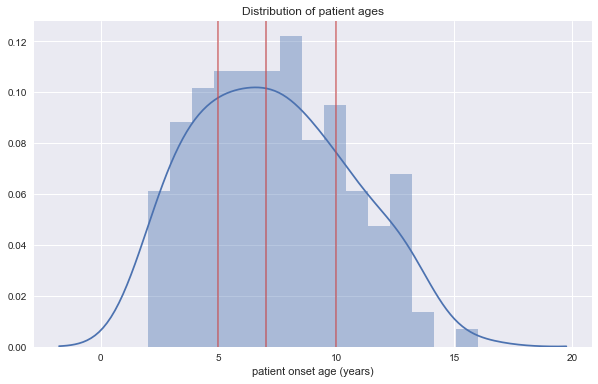

In [7]:
# plot distribtuion of patients ages
data_age = pediatric_data['patient.patientonsetageyear']
ax = sns.distplot(data_age, bins=15, kde=True);
ax.set_xlabel('patient onset age (years)');
ax.set_title('Distribution of patient ages');

# plot the quartiles
for q in [0.25,0.5,0.75]:
    ax.axvline(data_age.quantile(q), 0, 1, color='C2', alpha=0.7)

### Exploring types of adverse response outcomes

Similar to our analysis for the full database (presented in the [Exploring_OpenFDA_Adverse_Reactions notebook](https://github.com/ambevan/OpenFDA_Case_Study/blob/master/Exploring_OpenFDA_Adverse_Reactions.ipynb)), we can now perform some basic analysis and exploration of the cleaned pediatric dataset before building a more sophisticated model. We are primarily interested in the severity of the adverse response and so we start by exploring this feature.

We being by considering the relative proportions of seriousness outcomes in the data.

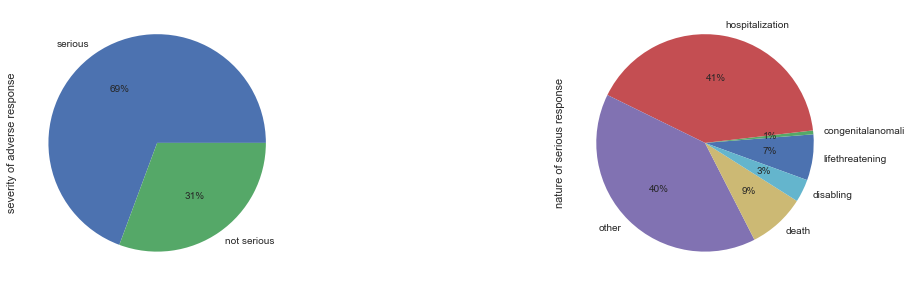

In [8]:
# create pie chart for serious vs not serious
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,5))
pediatric_data.serious.value_counts().plot.pie(labels=['serious','not serious'], ax=ax1, autopct='%1.0f%%');
ax1.set_ylabel('severity of adverse response');

# create pie chart showing all seriousness outcomes
seriousness_col_names = ['seriousnesslifethreatening',
                         'seriousnesscongenitalanomali',
                         'seriousnesshospitalization', 
                         'seriousnessother',
                         'seriousnessdeath' ,
                         'seriousnessdisabling'
                        ]
labels = [item.replace('seriousness','') for item in seriousness_col_names]
df_serious = pediatric_data[seriousness_col_names]
df_serious.sum().plot.pie(ax=ax2, autopct='%1.0f%%', labels=labels, startangle=-20)
ax2.set_ylabel('nature of serious response');

We can see that the fraction of reported serious adverse responses is similar to the entire population calculated in our [population study](https://github.com/ambevan/OpenFDA_Case_Study/blob/master/Exploring_OpenFDA_Adverse_Reactions.ipynb) (54% compared to 59%). Of those where the nature of the serious reponse was reported, the majority (60%) reported a response that did not result in death, disability, congenital anomali, a threat to life or hospitalisation.

Two different but comparable metrics exist within the database that give an indication of severity. We can gain some undersading of the accuracy of the data by comparing these metrics. We know whether the outcome was classified as 'serious' or 'not serious'. We also have the nature of the outcome as falling into one of these categories:

* 1 = Recovered/resolved
* 2 = Recovering/resolving
* 3 = Not recovered/not resolved
* 4 = Recovered/resolved with sequelae (consequent health issues)
* 5 = Fatal
* 6 = Unknown

We can examine the relative frequencies of these outcomes in our data (ignoring any blanks or unknowns).

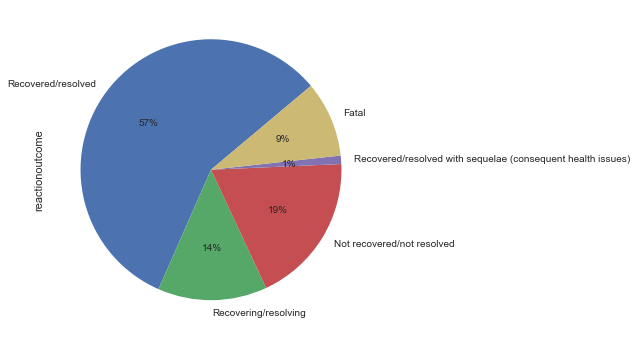

In [9]:
# count and plot frequencies of patient coutcomes
outcome_df = pediatric_data.reactionoutcome.value_counts()
outcome_df.sort_index(inplace=True)
labels_dict = {1 : 'Recovered/resolved',
               2 : 'Recovering/resolving',
               3 : 'Not recovered/not resolved',
               4 : 'Recovered/resolved with sequelae (consequent health issues)',
               5 : 'Fatal',
               6 : 'Unknown'
              }
ax1 = outcome_df[outcome_df.index != 6].plot.pie(autopct='%1.0f%%', labels=labels_dict.values(), startangle=40);                 

Some categories can be compared directly. For example the number of reports listing the outcome as 'death' is 11% by this metric compared to 8% by the feature 'seriousness outcome'. When combined with the relative sparsity of entries in teh seriousness outcome fields, we might infer that this metric may be more reliable.

It is noteworthy that many reports indicate multiple serious outcomes, for example hospitalization and death are not mutually exclusive and consequently they are not mutually exclusive. 

### Exploring the impact of age on adverse response outcomes

In [10]:
pediatric_data.groupby('serious').mean()

,index,reporttype,primarysource.qualification,patient.patientsex,seriousnessother,seriousnesshospitalization,seriousnesslifethreatening,seriousnessdeath,seriousnessdisabling,seriousnesscongenitalanomali,reactionoutcome,patient.patientonsetageyear
serious,,,,,,,,,,,,
0,78.229508,1.032787,4.049180,1.517857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.213115,6.915064
1,109.181159,1.369565,2.681159,1.369231,0.507246,0.521739,0.086957,0.108696,0.043478,0.007246,3.451852,7.507862


It seems that reports of serious adverse effects are more likely to be seen in slightly younger patients. We consdier their relative distributions and compare them at a 95% significane level using a z-test.

z = -0.136  critical value = 1.64
Do not reject null hypothesis. Insufficiest evidence for dependence.


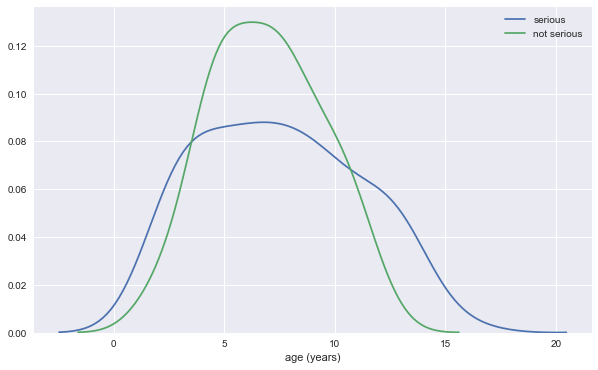

In [11]:
# plot two distribution plots comparing serious and not serious distributions
fig = plt.figure()
serious_1 = pediatric_data.loc[pediatric_data.serious==1, 'patient.patientonsetageyear']
serious_0 = pediatric_data.loc[pediatric_data.serious==0, 'patient.patientonsetageyear']
sns.kdeplot(serious_1, label='serious');
sns.kdeplot(serious_0, label='not serious');
plt.xlabel('age (years)');

# perform z test to compare means of distributions
# at 95% significant level
z = process_data.z_test(serious_0,serious_1, 0.95)

Whilst the 'not serious' responses are more skewed to older children, there is not enough evidence here to reject the null hypothesis that age is a significant factor in the severity of adverse reports.

### Exploring the impact of sex on adverse response outcomes

We can also consider the correlation with sex using a contingency table. 

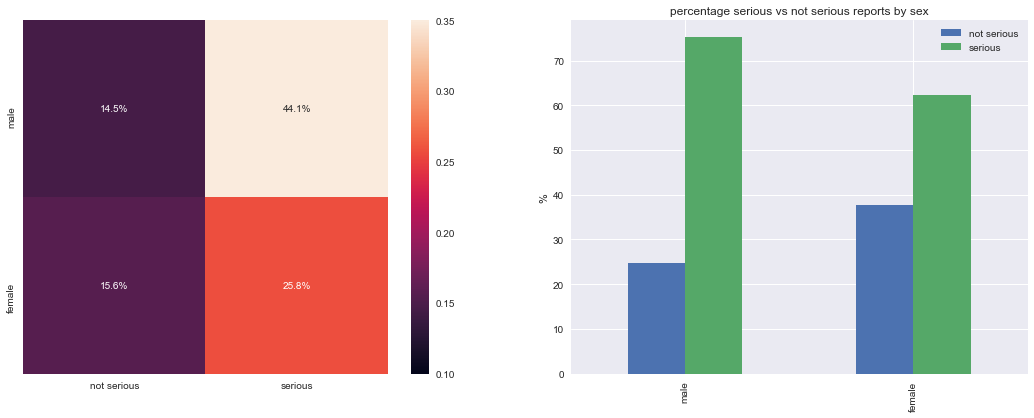

In [12]:
# create a pivot table on sex and serious
pivot_tb = process_data.calculate_serious_pivot(pediatric_data, 'patient.patientsex')
tb = pivot_tb.drop(columns=['total','not serious %','serious %'])
tb = tb.divide(tb.sum().sum())

# plot heatmap of contingency table 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,6.5))
ax1 = sns.heatmap(tb,vmin=0.10,vmax=0.35,
                 #norm=LogNorm(vmin=sub_data.min().min(), vmax=sub_data.max().max()),
                 annot=True,
                fmt='.1%', ax=ax1);
ax1.set_xlabel('');
ax1.set_ylabel('');
ax1.set_yticklabels(['male','female']);

# plot bar chart showing relative frequencies of serious/not serious by sex 
process_data.plot_serious_pivot(pivot_tb, 'route', ax2)
ax2.set_title('percentage serious vs not serious reports by sex');
ax2.set_xticklabels(['male','female']);
ax2.set_xlabel('');
ax2.set_ylabel('%');

We can see that there are significantly more reports of adverse reponses in male patients in the database. This might suggest that male patients are more likely to suffer adverse respones or that they are more likely to report adverse responses than female patients (or both). 

One indication that suggests male patients might simply be more likely to report adverse effects (either directly or through a clinician) is that, of female reports, 55% of reports were for serious adverse effects compared to 45% for not serious. The number of serious and non-serious adverse reports for male patients in the data is 50:50.

We can calculate pearson's $\chi^2$ correlation coefficient to understand whether these results are significant (i.e. whether, for a given confidence level, there is a correlation between sex and severity of response). We will choose a 99\% confidence interval. 

In [13]:
process_data.significance_test(pivot_tb[['not serious','serious']], 0.99)

dof = 1  probability = 0.990 | critical = 6.635   chi2 = 2.978

Do not reject null hypothesis. Insufficiest evidence for dependence.


We find that there is sufficient evidence at the 99% significance level to reject the null hypothesis that there is no dependency between gender and the serious status of the report. This feature may be useful in a predictive model.

### Exploring the impact of country on adverse response outcomes

A similar analysis is performed on the country in which the adverse response took place.

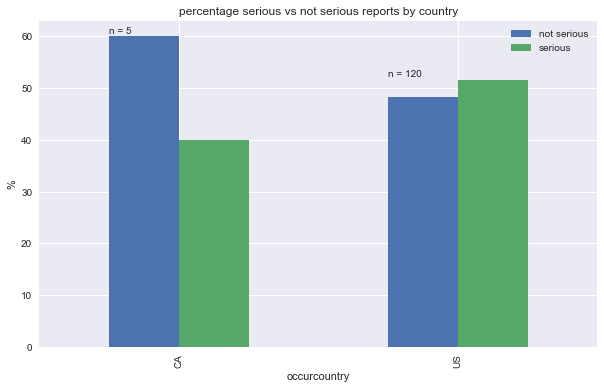

dof = 1  probability = 0.990 | critical = 6.635   chi2 = 0.003

Do not reject null hypothesis. Insufficiest evidence for dependence.


In [20]:
pivot_tb = process_data.calculate_serious_pivot(pediatric_data, 'occurcountry')
ax = process_data.plot_serious_pivot(pivot_tb, 'occurcountry', annotate=True)
ax.set_title('percentage serious vs not serious reports by country');
plt.show()

# calculate significance
process_data.significance_test(pivot_tb[['not serious','serious']], 0.99) #consider appropriateness of pearson's chi2 here (US dominates)

We find in this case also that, at the 99% significance level, there is sufficient evidence to reject the null hypothesis (i.e. that there is no correlation). This feature may be useful in a predictive model.

### Exploring the impact of drug administration route on adverse response outcomes

We repeat the process again exploring the possibility that adverse response severity may be influenced by the administration route. 

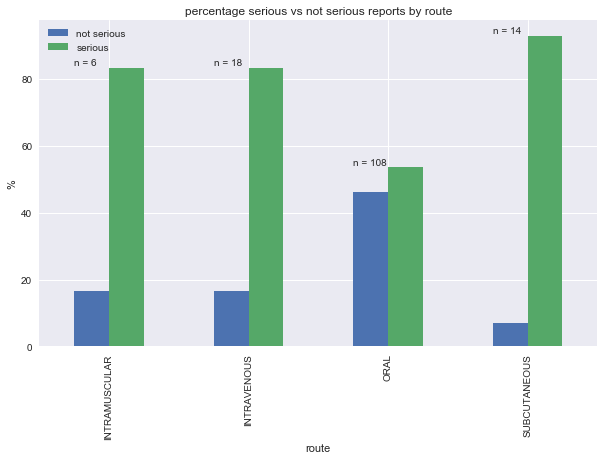

dof = 3  probability = 0.990 | critical = 11.345   chi2 = 13.488

Reject null hypothesis. Variables dependent at the 99% confidence level.


In [21]:
# calculate pivot table for severity against drug administration route
pivot_tb = process_data.calculate_serious_pivot(pediatric_data, 'route')
ax = process_data.plot_serious_pivot(pivot_tb, 'route', annotate=True)
ax.set_title('percentage serious vs not serious reports by route');
plt.show()

# calculate significance
process_data.significance_test(pivot_tb[['not serious','serious']], 0.99)

We find that, again, there enough evidence at a 99% significance level to reject the null hypothesis. 

</br>

We have discovered at least three factors that are correlated with the severity of the adverse response reports. With further time, interpretation of these correlations would benefit from comparison to general population data, a larger dataset and a more detailed understanding how and why adverse reports are made to the database. 

## Logistic Regression model

I am interested to construct a mode to predict the severity of adverse respones given certain information about a patient and the drug(s) that they are taking. The model would require significant fine tuning taking longer than the time available to complete this task. However, I include a representative approach using logistic regression to classify severity as serious or not serious. This simple model performs poorly but a variety of approaches might improve the accuracy of the model. I discuss these below.

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import process_data as process

I will establish a simple model based only on gender, age of patient and drug administration route. Initially the data needs further cleaning and preprocesing. 

#### Further cleaning of the data

In [23]:
# Shuffle the data in case it is sorted
data = pediatric_data.sample(frac=1).reset_index(drop=True)

# Remove all rows with no gender specified 
# (could have alternatively mapped to additional category)
print(f"{data['patient.patientsex'].isna().sum()} of {data['index'].count()} " 
      f"rows with missing sex removed "
     f"({data['patient.patientsex'].isna().sum()/data['index'].count():.2%})")
data = data[data['patient.patientsex'].notna()]

# Due to small numbers, group least prevalent routes into 'other'
# Kepp only most prevalent routes (>10% of data)
data = process.map_routes(data, 0.1)

# Map routes with missing values to new category 'unknown'
data.route_summary = data.route_summary.fillna('UNKNOWN')

13 of 199 rows with missing sex removed (6.53%)


#### Impute missing values and construct logistic regressor

In [24]:
# Select features to model
X = data[['patient.patientsex', 'patient.patientonsetageyear', 'route_summary']]
y = data['serious']

# Split into training data and validation data (consider cross-validation later)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

# Imputation: list categorical and numerical columns
cols_cat = ['route_summary']
patient_age = 'patient.patientonsetageyear'
imputed_X_train = X_train.copy()
imputed_X_valid = X_valid.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in cols_cat:
    imputed_X_train[col] = label_encoder.fit_transform(X_train[col].astype(str))
    imputed_X_valid[col] = label_encoder.transform(X_valid[col].astype(str))

# Imputation: replace missing numerical data with mean value
process.impute_on_mean(imputed_X_train, 'patient.patientonsetageyear')
process.impute_on_mean(imputed_X_valid, 'patient.patientonsetageyear')

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

# define logistic regression model
log_reg = LogisticRegression();
log_reg.fit(imputed_X_train, y_train);

#### Determine accuracy of model

Accuracy of logistic regression classifier on validation set: 0.70


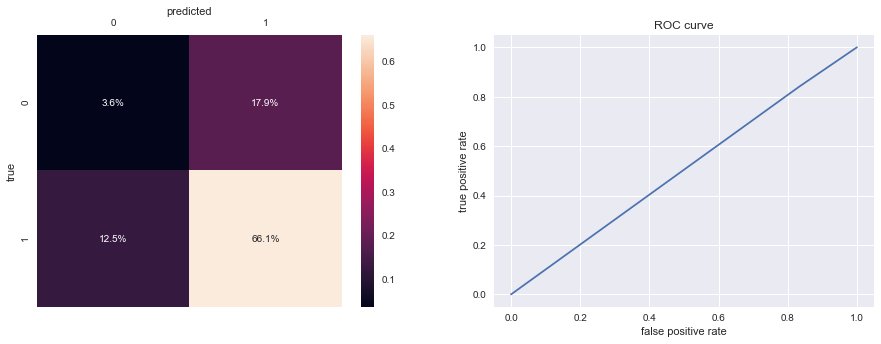

              precision    recall  f1-score   support

           0       0.22      0.17      0.19        12
           1       0.79      0.84      0.81        44

    accuracy                           0.70        56
   macro avg       0.50      0.50      0.50        56
weighted avg       0.67      0.70      0.68        56



In [25]:
# predict 
y_pred = log_reg.predict(imputed_X_valid)
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(log_reg.score(imputed_X_valid, y_valid)))
confusion_matrix = metrics.confusion_matrix(y_valid, y_pred)
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.heatmap(confusion_matrix/np.sum(confusion_matrix),annot=True,fmt='.1%',ax=ax1);
ax1.set_xlabel('predicted');
ax1.set_ylabel('true');
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top');

#plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred)
ax2.plot(fpr, tpr);
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('ROC curve')
plt.show()

print(metrics.classification_report(y_valid, y_pred))

The accuracy is extremely poor for this model (little better than random). There are likely many reasons for this and I list possible next steps to improve the model below.

#### Next steps to improve the model

* Increase the volume of data
* Increase the number of features (e.g. country, drug type, pediatric indication, prescription/OTC)
* Balance the dataset
* Reintroduce less common administration routes
* Alter encoding (use one-hot encoding)
* Cross-validation
* Alternative approaches e.g random forest or XGBoost

Additionally, I would build the code into a pipeline rather than having each step as laid out above.

## Conclusions

I have explored the FDA Adverse Reaction System and summaried the data it contains in [the first notebook](https://github.com/ambevan/OpenFDA_Case_Study/blob/master/Exploring_OpenFDA_Adverse_Reactions.ipynb). Simple frequency plots and calculations are performed to understand where reports comes from, the number of reports over time, the gender breakdown of reports and the severity of the adverse responses reported.

In a second stage, I have pulled records directly from the data to create a dataset of 5000 reports of adverse respones in the patient age group category 'children'. Using these data, I have examined the correlation of severity of response with various other reported features including age, gender, drug administration route and country. In all cases except age, a statistically significant correlation is observed. The analysis could be improved by ensuring balanced samples and accounting for variations within the population at large. A larger dataset would also produce more reliable results. Given the age range found in the 'child' category, it would likely be sensible to include all pediatric patient age ranges.

In a final stage, I have constructed a illustrative logistic regression model to predict a response as 'serious' or 'not serious' as defined by the FDA. This model is overly simplistic and required further refinement both for reliability and for accuracy.